In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/mini_projects/_E-09_kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 노드에서 진행된 전처리 과정

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)   # date를 int로 바꿔서 date도 feature로 써준다
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

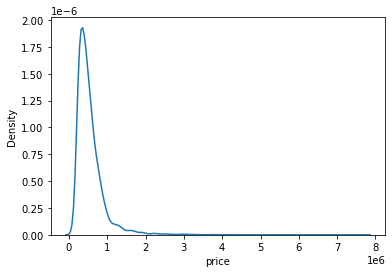

In [9]:
sns.kdeplot(y)               # kde 확률밀도 그래프, 연속된 확률분포를 나타낸다, kernel density estimate 커널 밀도 추정 그래프 ???
plt.show()

In [10]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

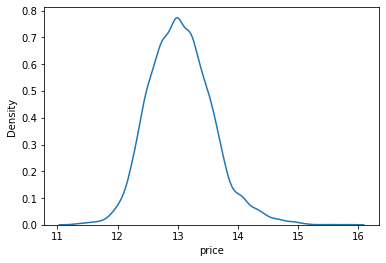

In [11]:
sns.kdeplot(y)
plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   int64  
 1   bedrooms       6468 non-null   int64  
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   int64  
 4   sqft_lot       6468 non-null   int64  
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   int64  
 11  sqft_basement  6468 non-null   int64  
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  zipcode        6468 non-null   int64  
 15  lat            6468 non-null   float64
 16  long           6468 non-null   float64
 17  sqft_living15  6468 non-null   int64  
 18  sqft_lot

# 모델 생성

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [15]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))



In [16]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor



In [17]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]



In [18]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [19]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

# 그리드 탐색

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
# 탐색할 파라미터 종류         
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [22]:
model = LGBMRegressor(random_state=random_state)  # 탐색할 파라미터 종류는 XGBRegressor 에 관련된 걸 넣고 모델은 왜 LGBMRegressor를 쓰지?



In [23]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

# 어떤 모델을 쓸 건지 : 각 모델의 특징 알아야 한다.
# 모델에 따라 어떤 점수체계를 쓸 건지

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.0s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
grid_model.cv_results_

{'mean_fit_time': array([0.0597487 , 0.05794725, 0.10537291, 0.16958909]),
 'std_fit_time': array([0.00409408, 0.00432708, 0.00597731, 0.0096829 ]),
 'mean_score_time': array([0.00399566, 0.00496259, 0.00753336, 0.01244969]),
 'std_score_time': array([0.00116437, 0.00040302, 0.00053046, 0.00126996]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [25]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [26]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [27]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [28]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [29]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [30]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


# 하나의 함수로 만들면

In [31]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

# LGBMRegressor 시험

In [32]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.5s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


# 예측

In [33]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [34]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

# 제출 파일 저장

In [35]:
data_dir = os.getenv('HOME')+'/mini_projects/_E-09_kaggle/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [36]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [37]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel/mini_projects/_E-09_kaggle/data/submission_lgbm_RMSLE_0.164399.csv


# 하나의 함수로

In [38]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/mini_projects/_E-09_kaggle/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [39]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/home/aiffel/mini_projects/_E-09_kaggle/data/submission_lgbm_RMSLE_0.0168.csv saved!


# 프로젝트 시작.
## 노드에 있는 코드 그대로 썼을 때 score   
   
1115688점

![첫번째](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcfHho9%2FbtqXu4enwDn%2FGkbpSmJlFmKBQ9vF5inRhK%2Fimg.png)

# 1. 하이퍼 파라미터 조정 실험

In [41]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.9s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
1,10,200,-0.026188,0.161828
3,20,200,-0.026245,0.162003
0,10,100,-0.027027,0.164399
2,20,100,-0.027051,0.164472


In [58]:
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
1,10,400,-0.026121,0.161619
0,10,200,-0.026188,0.161828
3,20,400,-0.026206,0.161883
2,20,200,-0.026245,0.162003


In [43]:
param_grid = {
    'n_estimators': [400, 800],
    'max_depth': [10, 20],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.6s finished


,max_depth,n_estimators,score,RMSLE
0,10,400,-0.026121,0.161619
2,20,400,-0.026206,0.161883
1,10,800,-0.026552,0.162947
3,20,800,-0.026603,0.163103


# 하이퍼 파라미터 실험 결과
파라미터 실험 결과 n_estimators는 400, max_depth는 10일 때 RMSLE가 0.161619 로   
노드에서 처음 세팅 된 n_estimators는 100, max_depth는 10일 때 RMSLE 0.164399 보다   
0.00278 낮게 나왔다.   
   
n_estimators는 200에서 400으로 올렸을 때 RMSLE가 0.0002 정도 낮아졌지만   
400이 넘어가면 오히려 높아졌다.   

max_depth는 10보다 큰 게 의미가 없었다.   
   

   

   

# 2. 모델 변경 실험

In [45]:
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20],
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   58.5s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


,max_depth,n_estimators,score,RMSLE
0,10,200,-0.030583,0.174879
1,10,400,-0.030583,0.174879
2,20,200,-0.032958,0.181544
3,20,400,-0.032958,0.181544


**1. XGBRegressor는 LGBMRegressor보다 시간도 오래 걸리고 점수 개선도 없었다.**

In [46]:
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20],
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   43.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min finished


,max_depth,n_estimators,score,RMSLE
0,10,200,-0.029427,0.171542
1,10,400,-0.029481,0.171700
3,20,400,-0.052061,0.228168
2,20,200,-0.052061,0.228168


**2. GradientBoostingRegressor는 XGBRegressor 보다 시간이 더 오래 걸리고 점수도 별 차이가 없다.**

In [47]:
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20],
}

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   28.5s remaining:   42.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.0min finished


,max_depth,n_estimators,score,RMSLE
3,20,400,-0.031498,0.177476
2,20,200,-0.031537,0.177587
1,10,400,-0.034933,0.186903
0,10,200,-0.034939,0.186920


**3 .RandomForestRegressor는 XGBRegressor 와 비슷하다.**

# 모델 변경 실험 결과
###  세 모델 중 LGBMRegressor가 가장 좋은 성능을 냈다.


# 하이퍼 파라미터 조정 후 LGBMRegressor 점수 결과   
첫번째 노드의 점수 115688 에서 하이퍼 파라미터를 조정한 LGBMRegressor 모델의 점수는 111680 점으로 약 4000점 가량 개선됐다.   
획기적으로 개선되기 위해선   
피쳐 엔지니어링과 모델의 파격이 필요해보인다.   

![두번째](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzFuXm%2FbtqXrCvMIFh%2FcQDBJEv8qsEkCaBuP2WZ6K%2Fimg.png)

# 3. 앙상블 기법 실험

### 모델은 성능이 가장 좋았던 LGBMRegressor, RandomForestRegressor, XGBRegressor 순으로 3개를 뽑았다

In [65]:
xgboost = XGBRegressor(random_state=2019)
lightgbm = LGBMRegressor(random_state=2019)
rdforest = RandomForestRegressor(random_state=2019)

models = [{'model':rdforest, 'name':'RandomForestRegressor'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [66]:
def get_cv_score(models):                                                              
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)), 
                                             kf=kfold))
get_cv_score(models)

Model RandomForestRegressor CV score : 0.8853
Model XGBoost CV score : 0.8973
Model LightGBM CV score : 0.9025


In [71]:
def AveragingBlending(models, train, y, test):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, train, y, test)
y_pred

array([13.1062032 , 13.06797372, 14.08226662, ..., 13.04908802,
       12.70356968, 13.00996755])

In [72]:
prediction = np.expm1(y_pred)
prediction

array([ 491983.85019635,  473530.5033171 , 1305720.88913075, ...,
        464671.44730007,  328918.94669932,  446844.22192839])

![세번째](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FqsTiU%2FbtqXBWNf3b4%2F6Rjk8JJLK5955OTIQkGXN1%2Fimg.png)

# 앙상블 결과   
앙상블을 했을 때 오히려 점수가 대폭 나빠졌다.   
안하느니만 못한 결과가 나왔다.   
   
**왜 그런걸까?**

# 4. feature engineering

## feature 분석

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

**1. 5번과 6번 feature를 삭제해보겠다.**       
sqft_living : 주거 공간의 평방 피트   
sqft_lot : 부지의 평방 피트    
   
**삭제 근거** : 20번과 21번의 sqft_living15, sqft_lot15 feature와 중복되는 데이터라고 판단된다.   


**2. 17번 feature를 삭제해보겠다.**  
zipcode : 우편번호   
   
**삭제 근거** : 우편번호가 값과 연관이 있으려면 주소정보가 담겨 있기 때문일 텐데, 18번 19번 feature의 위도, 경도와 중복된다고 판단된다

**2. 2번 date를 삭제해보겠다.**  
date :집을 구매한 날짜
   
**삭제 근거** : 집을 구매한 년도는 전체 데이터가 2014년에서 2015년, 2개년에 국한돼 있다.   
정확히는 2014년 5월에서 2015년 5월 사이에 분포한다.   
이정도 분포로는 집을 구매한 날짜가 집값에 미치는 영향을 고려되기에 미미하다.

In [76]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
data_dir = os.getenv('HOME')+'/mini_projects/_E-09_kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [78]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [79]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [88]:
train['date'].max()

'20150514T000000'

In [89]:
train['date'].min()

'20140502T000000'

# 데이터 전처리, EDA

In [90]:
y = train['price']
del train['price']

In [91]:
del train['id']
del test['id']
del train['date']
del test['date']
del train['sqft_living']
del test['sqft_living']
del train['sqft_lot']
del test['sqft_lot']
del train['zipcode']
del test['zipcode']

In [92]:
print(train.columns)
print(test.columns)

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [93]:
train_len = len(train)
data = pd.concat((train, test), axis=0)        # 전체 데이터를 탐색해보기 위해 두 데이터를 합친다
print(train_len)                              # 나중에 다시 분리하기 위해 train 데이터 개수를 저장한다.
print(len(data))

15035
21503


In [101]:
data.head(100)

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,2,1.00,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
2,3,2.00,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
3,3,2.25,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
4,3,1.50,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,2.50,2.0,0,0,4,9,3670,0,1994,0,47.7421,-122.026,2840,87991
96,3,2.00,2.0,0,0,3,8,1360,0,1990,0,47.6838,-122.353,1500,3090
97,3,1.00,1.5,0,0,3,7,1110,0,1947,0,47.6550,-122.359,1420,5000
98,4,3.25,2.0,0,3,3,12,3540,1640,2006,0,47.5620,-122.162,3160,9750


## 결측치 확인

<AxesSubplot:>

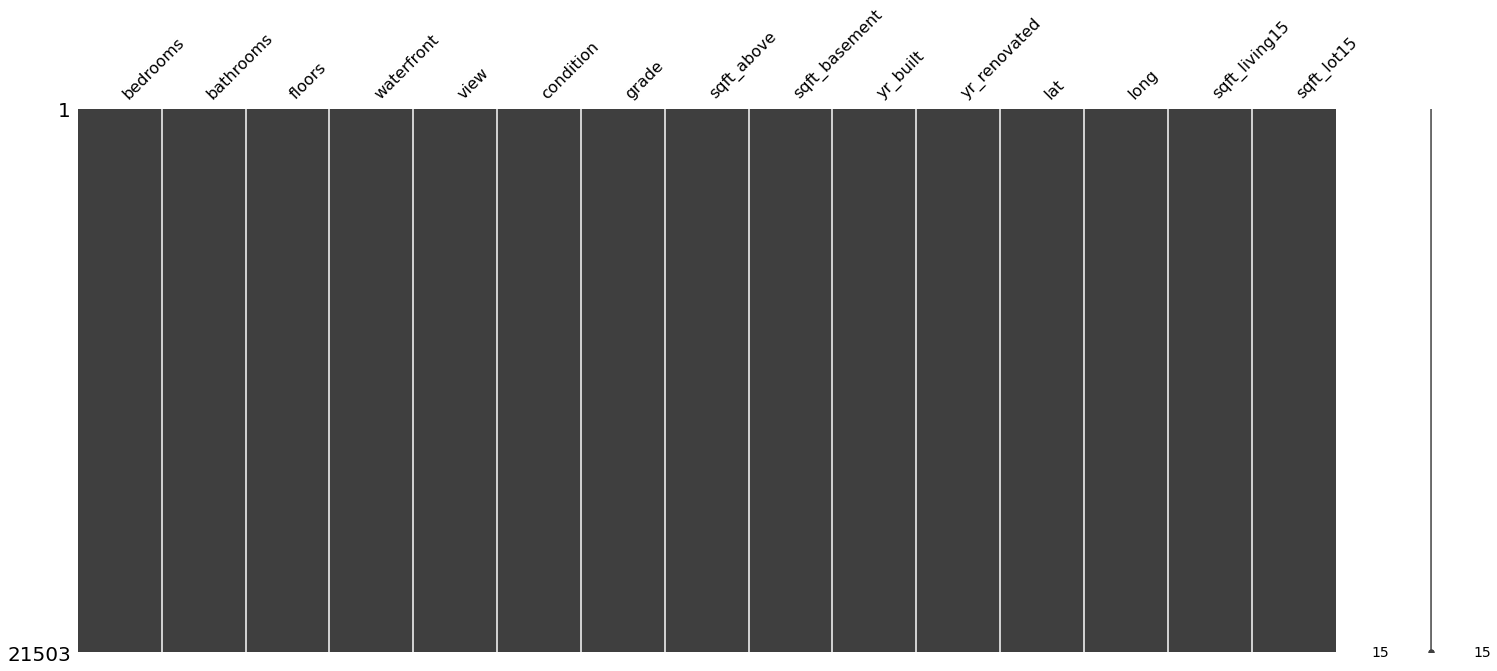

In [95]:
msno.matrix(data)

### 각 변수들의 분포 확인

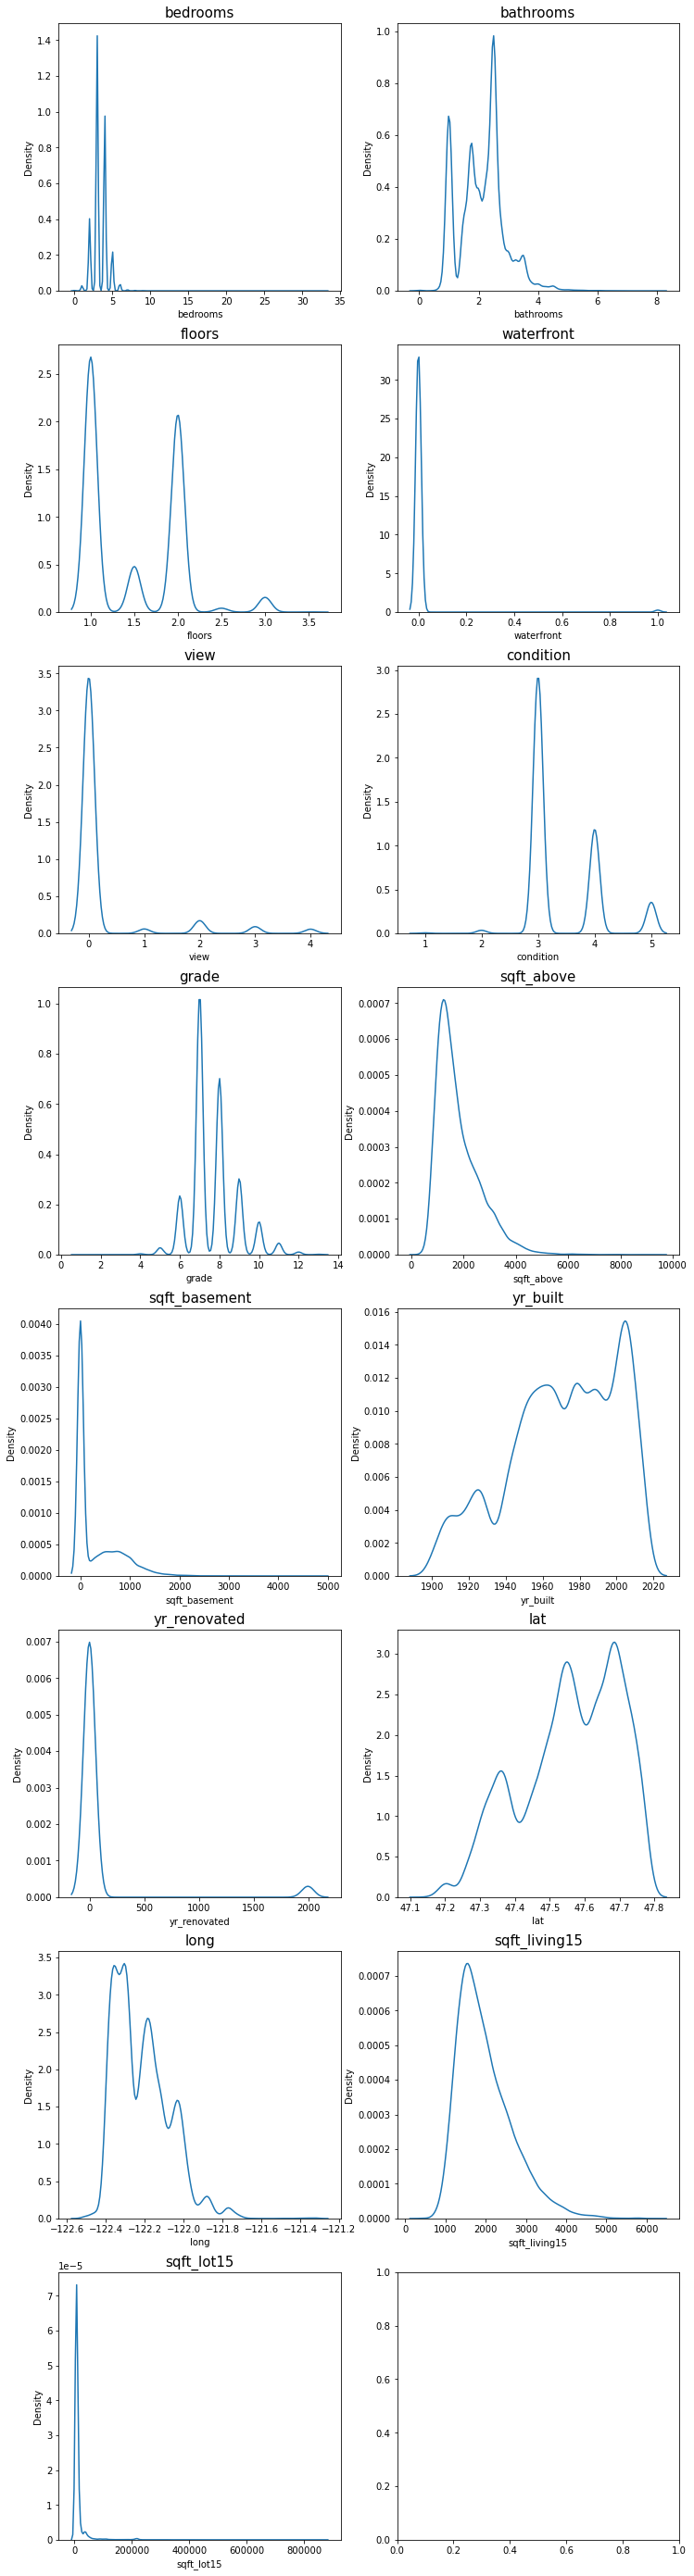

In [103]:
fig, ax = plt.subplots(8, 2, figsize=(12, 50))   

count = 0
columns = data.columns
for row in range(8):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)                
        count += 1
        if count == 15 :
            break

### 데이터 분포 개선

In [104]:
skew_columns = ['bedrooms', 'sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

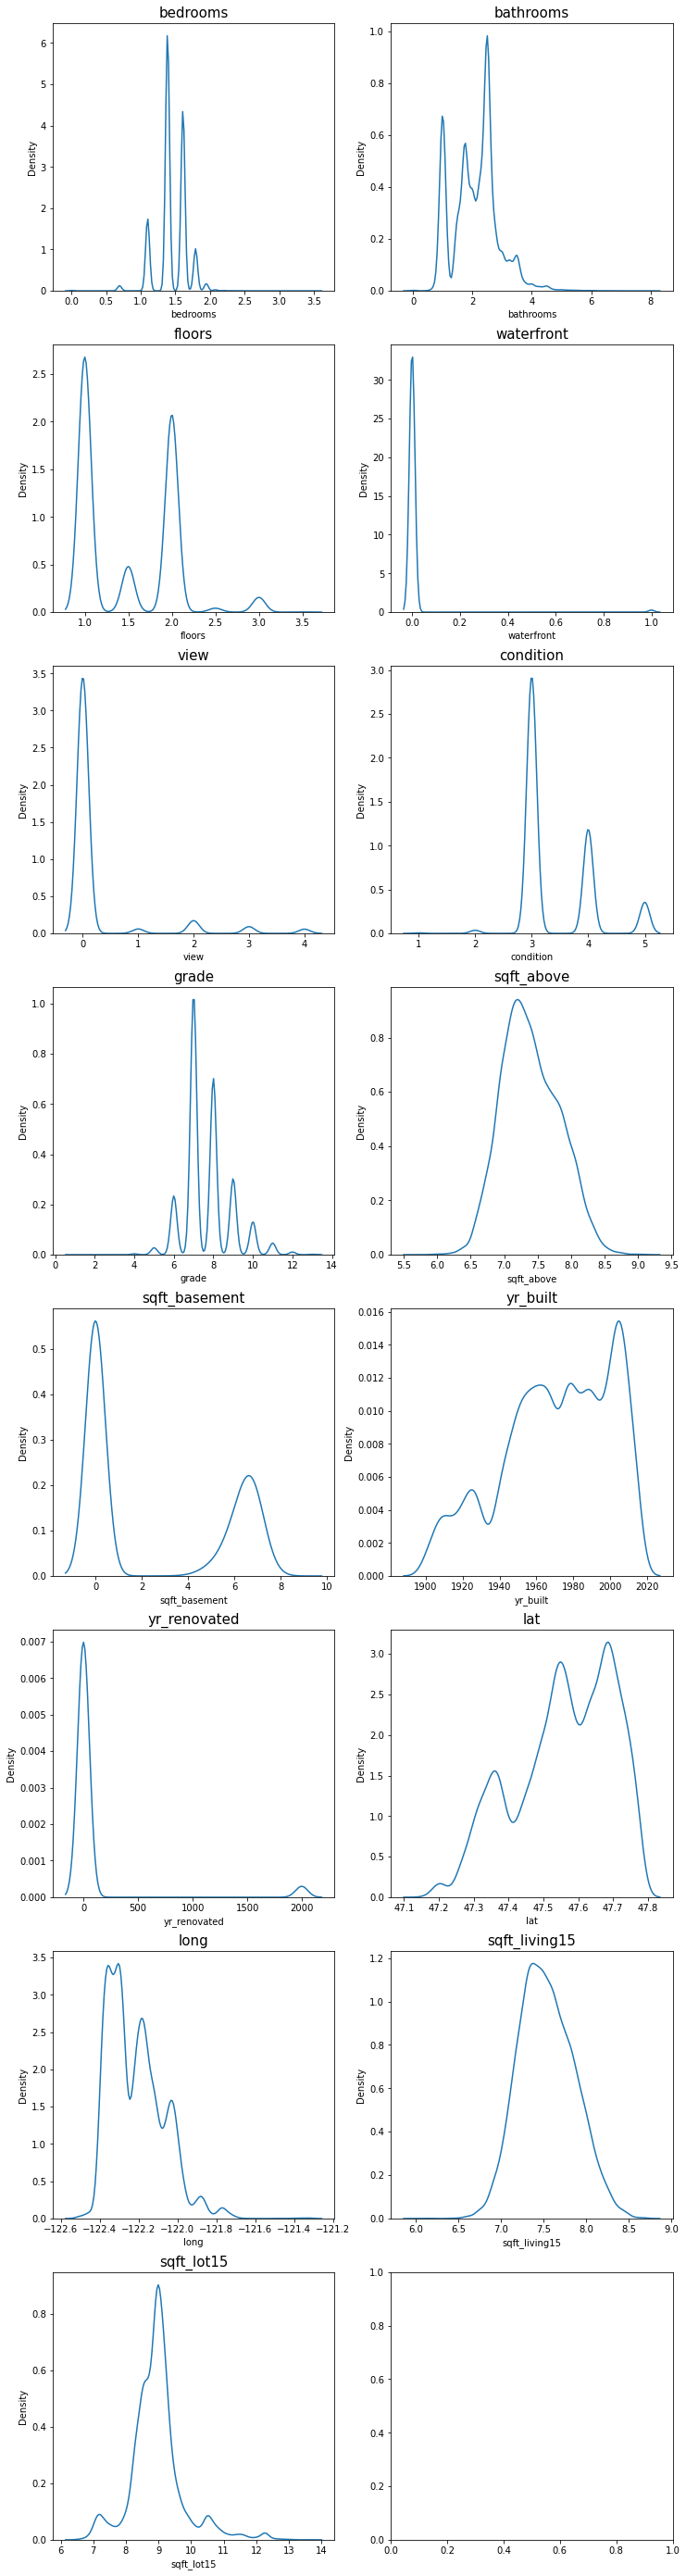

In [105]:
fig, ax = plt.subplots(8, 2, figsize=(12, 50))   

count = 0
columns = data.columns
for row in range(8):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)                
        count += 1
        if count == 15 :
            break

In [106]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 15)
(6468, 15)


In [107]:
y = np.log1p(y)

In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15035 non-null  float64
 1   bathrooms      15035 non-null  float64
 2   floors         15035 non-null  float64
 3   waterfront     15035 non-null  int64  
 4   view           15035 non-null  int64  
 5   condition      15035 non-null  int64  
 6   grade          15035 non-null  int64  
 7   sqft_above     15035 non-null  float64
 8   sqft_basement  15035 non-null  float64
 9   yr_built       15035 non-null  int64  
 10  yr_renovated   15035 non-null  int64  
 11  lat            15035 non-null  float64
 12  long           15035 non-null  float64
 13  sqft_living15  15035 non-null  float64
 14  sqft_lot15     15035 non-null  float64
dtypes: float64(9), int64(6)
memory usage: 1.8 MB


In [109]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6468 entries, 0 to 6467
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       6468 non-null   float64
 1   bathrooms      6468 non-null   float64
 2   floors         6468 non-null   float64
 3   waterfront     6468 non-null   int64  
 4   view           6468 non-null   int64  
 5   condition      6468 non-null   int64  
 6   grade          6468 non-null   int64  
 7   sqft_above     6468 non-null   float64
 8   sqft_basement  6468 non-null   float64
 9   yr_built       6468 non-null   int64  
 10  yr_renovated   6468 non-null   int64  
 11  lat            6468 non-null   float64
 12  long           6468 non-null   float64
 13  sqft_living15  6468 non-null   float64
 14  sqft_lot15     6468 non-null   float64
dtypes: float64(9), int64(6)
memory usage: 808.5 KB


# 훈련 및 예측

In [111]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor


In [116]:
model = LGBMRegressor(max_depth=10, n_estimators=400, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.11072573, 13.00678476, 14.07241017, ..., 13.08874339,
       12.71132457, 12.91333645])

In [117]:
prediction = np.expm1(prediction)
prediction

array([ 494213.90587193,  445424.26501867, 1292914.33149692, ...,
        483468.44084629,  331479.60075083,  405685.69215631])

In [121]:
data_dir = os.getenv('HOME')+'/mini_projects/_E-09_kaggle/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel/mini_projects/_E-09_kaggle/data/submission_lgbm_RMSLE_0.164399.csv


![네번째](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbNFv5H%2FbtqXobrNPuj%2FL2QpKZZH6Hd1irnzAvauZ0%2Fimg.png)

내 예상이 빗나갔다.   
feature 4개를 삭제했더니 스코어가 가장 나쁘다.   
해커톤에서 보았던   
lag 기법을 쓰면 될까?

# 프로젝트 진행 중 의문점

### 1. 아직까지 정규분포가 뭔지, normalization을 왜 해줘야 하는지 수학적으로 이해하지 못하고 있다.

### 2. 앙상블 기법이 분류가 아닌 예측 문제에 적용되면 성능이 오히려 하락할 수 있는 건가?

### 3. feature에 대한 이해가 부족하다

# 회고

가장 낮은 점수인 사람의 코드를 보니 노드에서 말한 stack이라는 용어가 보이는데   
뭔지 잘 모르겠다.   
   
가장 많은 표를 받은 사람의 코드를 보니   
내가 feature를 잘못 해석했다는 걸 알 수 있었다.   
어떤 모델을 쓰는지   
어떤 하이퍼 파리미터 조합을 취했는지가 스코어에 결정적인 영향을 미치려면   
그 전에 feature에 대한 완벽한 분석과 이해가 선행되어야 하고   
예측에 필요한 특징들을 만들어내야 하는 것 같다.   
또한   
lgbm 과 xgb를 각각 두 번씩 돌려서 Ensemble해 결과를 냈다.   
이 사람의 코드를 더 공부해봐야겠다.